In [110]:
# imports
import pandas as p
import folium
import os
import zipfile
from collections import Counter
import math
import matplotlib.pyplot as plt
import statistics as stats
import geopy.distance as geopydist # used for calculating geodesic distance
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import HDBSCAN
from datetime import datetime, timedelta


# constants
LAT_MIN = 18.76651
LAT_MAX = 22.63089
LON_MIN = -160.11085
LON_MAX = -154.38957
FOLDER_PATH = "../dataset/2019_01/"
SPEED_THRESHOLD = 0.3
KNOTS_CONST = 1.943845249221964 # constant used to convert from m/s to nautical knots

Extract only the data with the correct latitude and longitude values
This operation takes roughly 15-20 seconds per csv file (tested on csv files with > 1 million rows)

In [ ]:
final_df = p.DataFrame()

# list all the files in the specified directory
filenames = os.listdir(FOLDER_PATH)
# and sort them alphabetically
filenames.sort()
# for each file
for file_name in filenames:
    # only iterate over zip files
    if file_name.endswith('.zip'):
        file_path = os.path.join(FOLDER_PATH, file_name)
        # if the csv file has yet to be extracted
        csv_filename = file_name.replace(".zip", ".csv")
        if not(os.path.exists(os.path.join(FOLDER_PATH, csv_filename))):
            # open the zip file and extract it
            with zipfile.ZipFile(file_path, 'r') as zip_file:
                csv_filename = zip_file.namelist()[0]
                zip_file.extractall(FOLDER_PATH)
        # create a dataframe using the extracted csv file
        full_df = p.read_csv(os.path.join(FOLDER_PATH, csv_filename))
        # extract only the rows of interest (with LAT and LON values between the specified bounds)
        filtered_df = full_df[
                                (full_df['LAT'].between(LAT_MIN, LAT_MAX)) &
                                (full_df['LON'].between(LON_MIN, LON_MAX)) 
                            ]
        # and append the extracted rows to the final dataframe
        final_df = p.concat([final_df, filtered_df], ignore_index = True)

print(f"Final dataframe len: {final_df.shape[0]}")
print(final_df.head())
      
    

Separate code snippet used for exporting the final dataframe as a csv file.
This is necessary as the above code snippet takes ~8 minutes read and filter 31 csv files.
By exporting the resulting df as a csv file it's possible import it again for the following part of this notebook

In [97]:
#OUTPUT_PATH = os.getcwd()
OUTPUT_PATH = FOLDER_PATH
FILE_NAME = '2019_01.csv' #specify file name (don't forget the .csv extension)
#final_df.to_csv(OUTPUT_PATH + '/' + FILE_NAME, index = False)

#print(f"Final dataframe len: {final_df.shape[0]}")


Read the csv file and use it as the final data source
(The code snippet below should be used only if the code snippet #2 was not executed)

In [98]:
# read csv
final_df = p.read_csv(OUTPUT_PATH + FILE_NAME)
final_df.drop_duplicates(keep='first', inplace=True, ignore_index=True) # drop duplicates
final_df.BaseDateTime = p.to_datetime(final_df.BaseDateTime) # Convert DateTime into more readable format

print(f"Final dataframe len: {final_df.shape[0]}")

Final dataframe len: 1924108


Some stats about the imported dataframe</br>
In order to make the histogram below, occurrencies are rounded to the top hundred (ex: 33 -> 100, 244 -> 300, etc...)</br>
This is done in order to have an idea about how many ships have negligible amount of records.</br>
In the next code snippet (#10) the threshold is set to 100 and consequently all vessels with less than 100 data points are removed from the dataset</br>

Num of rows: 1924108
Num of vessels: 423
Avg entries for each vessel 4548.718676122931
Variance: 37071194.430148005
Standard Deviation: 6088.611863975893
Max entries found for the same ship: 28648
Min entries found for the same ship: 1
Final dataframe len: 1924108, num of vessels: 423


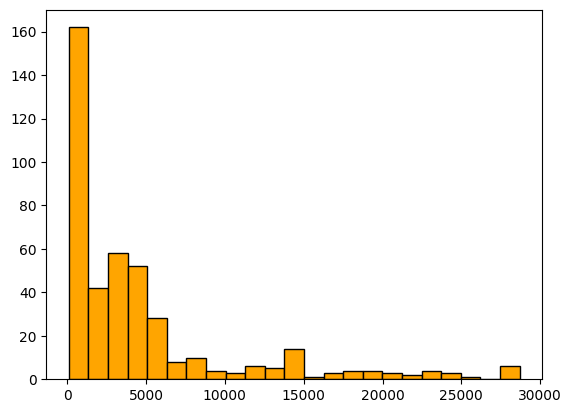

In [99]:
# Number of entries (number of rows of the dataframe)
num_of_rows = final_df.index.shape[0]
print("Num of rows: " + str(num_of_rows))

# Extract all the unique MMSIs
unique_vessels_ids = p.unique(final_df['MMSI']).tolist()
num_of_vessels = len(unique_vessels_ids)
print("Num of vessels: " + str(num_of_vessels))

# Calculate the exact number of entries for each ship
vessels_entries_dict = dict(Counter(final_df['MMSI'].to_list())) # save it in a dict
vessels_entries = list(vessels_entries_dict.values()) # save just the values in a list
vessels_entries.sort()
rounded_vessels_entries = [math.ceil(x/100) * 100 for x in vessels_entries]

print(f"Avg entries for each vessel {stats.mean(vessels_entries)}")
print(f"Variance: {stats.variance(vessels_entries)}")
print(f"Standard Deviation: {stats.stdev(vessels_entries)}")
print(f"Max entries found for the same ship: {vessels_entries[-1]}")
print(f"Min entries found for the same ship: {vessels_entries[0]}")

n, bins, patches = plt.hist(x=rounded_vessels_entries, bins='auto', color='orange', edgecolor = 'black')


print(f"Final dataframe len: {final_df.shape[0]}, num of vessels: {len(vessels_entries)}")

Remove ships with not enough entries

In [100]:
THRESHOLD = 100

mmsi_to_be_removed = [x for x in vessels_entries_dict.keys() if vessels_entries_dict[x] <= THRESHOLD]
print(f"Final dataframe len: {final_df.shape[0]}, num of vessels: {len(vessels_entries)}, unwanted vessels: {len(mmsi_to_be_removed)}")
clean_df = final_df.copy()

for unwanted_mmsi in mmsi_to_be_removed:
    clean_df = clean_df.drop(clean_df[clean_df['MMSI'] == unwanted_mmsi].index)

clean_df.sort_values(by='BaseDateTime', inplace=True, ignore_index=True)

print(f"Cleaned dataframe len: {clean_df.shape[0]}, num of vessels: {len(p.unique(clean_df['MMSI']))}")

Final dataframe len: 1924108, num of vessels: 423, unwanted vessels: 71
Cleaned dataframe len: 1922770, num of vessels: 352


Export the cleaned dataframe in order to have a backup copy in a csv file

In [101]:
#OUTPUT_PATH = os.getcwd()
OUTPUT_PATH = FOLDER_PATH
FILE_NAME = 'cleaned_2019_01.csv' #specify file name (don't forget the .csv extension)
#clean_df.to_csv(OUTPUT_PATH + '/' + FILE_NAME, index = False)

#print(f"Final dataframe len: {final_df.shape[0]}")

Create a new histogram using the "cleaned" data from the clean_df

Avg entries for each vessel 5462.414772727273
Variance: 39581859.54827117
Standard Deviation: 6291.411570408597
Max entries found for the same ship: 28648
Min entries found for the same ship: 105


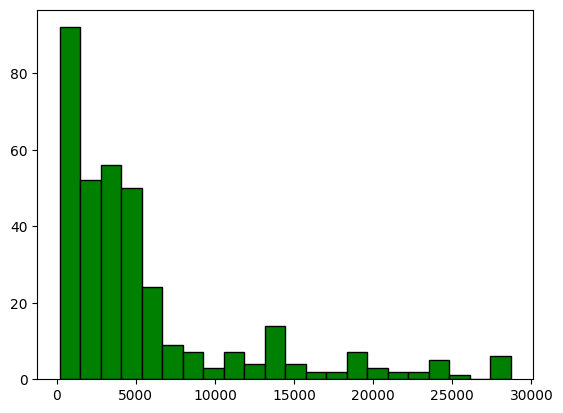

In [102]:
clean_vessel_entries = list(Counter(clean_df['MMSI'].to_list()).values())

rounded_clean_vessels_entries = [math.ceil(x/100) * 100 for x in clean_vessel_entries]

print(f"Avg entries for each vessel {stats.mean(clean_vessel_entries)}")
print(f"Variance: {stats.variance(clean_vessel_entries)}")
print(f"Standard Deviation: {stats.stdev(clean_vessel_entries)}")
print(f"Max entries found for the same ship: {max(clean_vessel_entries)}")
print(f"Min entries found for the same ship: {min(clean_vessel_entries)}")

n, bins, patches = plt.hist(x=rounded_clean_vessels_entries, bins='auto', color='green', edgecolor = 'black', )

Print a few points on the map just to check that everything works

In [ ]:
map = folium.Map(location=[21, -158], tiles="OpenStreetMap", zoom_start=9)

clean_df.sort_values(by='MMSI', inplace=True)

#test ranges (replace x and y below): [2:474], [474, 1364], [1364,1837], [1837:2285], [2285, 2725]
x = 2
y = 30000
# extract from the dataset latitude and longitude of the values in range [x:y)
loc = [[str(mmsi), lat, lon] for (mmsi, lat, lon) in zip(clean_df.iloc[x:y]['MMSI'], clean_df.iloc[x:y]['LAT'], clean_df.iloc[x:y]['LON'])]

appendDF = p.DataFrame(loc)
appendDF.columns = ['MMSI', 'LAT', 'LON'] # create a temporary df with the extracted mmsi, lat. and long. values

# CircleMarker requires each point to be added one by one
# The temp function below is applied to all points in the tempDF
def tempFunc(row):
    folium.CircleMarker(
        location=[row['LAT'],row['LON']],
        radius=0.5
        ).add_child(folium.Popup(row['MMSI'])).add_to(map)

# Using 'apply' with a custom function saves a bit of time (compared to a simple for-loop)
appendDF.apply(tempFunc, axis=1)

map 

Source: Pallotta, G., Vespe, M., & Bryan, K. (2013). Vessel Pattern Knowledge Discovery from AIS Data: A Framework for Anomaly Detection and Route Prediction. Entropy, 15(12), 2218–2245. https://doi.org/10.3390/e15062218

‌TREAD algorithm (pages 2223-2231)

In [104]:
def my_fun(timestamp_left, LAT_left, LON_left, timestamp_right, LAT_right, LON_right):
    first_coords = (LAT_left, LON_left)
    second_coords = (LAT_right, LON_right)
    meters = geopydist.distance(first_coords, second_coords).m
    seconds = (p.Timestamp(timestamp_right) - p.Timestamp(timestamp_left)).total_seconds()
    return round(((meters)/seconds) * KNOTS_CONST, 2) # Measured in knots

V_s = [] # List of dataframes. Each dataframe represents a Vessel (and its journey)

# From the full db, select only the necessary columns
clean_df = clean_df[['MMSI', 'BaseDateTime', 'LAT', 'LON', 'COG', 'SOG']].copy()
# Drop duplicates, just in case
clean_df.drop_duplicates(subset=['MMSI', 'BaseDateTime'], keep='first', inplace=True, ignore_index=True)

# for each ship
for mmsi in p.unique(clean_df['MMSI']):
    # Extract all points generated by the ship
    appendDF = p.DataFrame(clean_df[clean_df['MMSI'] == mmsi])
    # Add a new column for storing the average speed between the current point and the previous
    appendDF['Avg_Speed'] = np.nan
    # Add a new column for storing the status of the ship (according to TREAD algorithm, see above)
    appendDF['Status'] = np.nan
    # Rename the dataframe to the corresponding ship MMSI
    appendDF.Name = mmsi
    # reset the index of the dataframe
    appendDF.reset_index(inplace=True)

    # next step: calculate the avg_speed (distance/time) in order to find stationary points.
    # for the distance, the geodesic distance is used in order to account for earth curvature
    
    # save a shifted-by-one-row version of the db, so that "previous" points can be joined with "current" points
    shiftedDF = appendDF[['BaseDateTime','LAT', 'LON']].shift(1).copy()
    # the resulting df has (for each row) a pair of points. The left one is antecedent to the roght one
    pairsOfPointsDF = shiftedDF.iloc[1:].join(appendDF[['BaseDateTime', 'LAT', 'LON']].iloc[1:], lsuffix='_left', rsuffix='_right')
    # calculate average speed for each row of the 'pairsOfPointsDF' df (each row represents a pair of points)

    vectorized_function = np.vectorize(my_fun)
    appendDF.loc[1:, 'Avg_Speed'] = vectorized_function(pairsOfPointsDF['BaseDateTime_left'], 
                                                        pairsOfPointsDF['LAT_left'],
                                                        pairsOfPointsDF['LON_left'],
                                                        pairsOfPointsDF['BaseDateTime_right'],
                                                        pairsOfPointsDF['LAT_right'],
                                                        pairsOfPointsDF['LON_right']
                                                    )

    # The first row of each ship has its "Avg_Speed" field set equal to the SOG
    appendDF.at[appendDF.index[0], 'Avg_Speed'] = appendDF.at[appendDF.index[0], 'SOG']
    # drop the first column (generated during all the processing above)
    appendDF.drop('index', axis=1, inplace=True)
    # save the dataframe to a list
    V_s.append(appendDF)

print(V_s[0])

            MMSI        BaseDateTime       LAT        LON    COG  SOG  \
10640  338070127 2019-01-24 14:18:23  21.31309 -157.86718    0.0  0.0   
10641  338070127 2019-01-24 14:21:23  21.31310 -157.86716    0.0  0.0   
10642  338070127 2019-01-24 14:24:24  21.31310 -157.86717    0.0  0.0   
10643  338070127 2019-01-24 14:27:23  21.31309 -157.86714  142.5  0.9   
10644  338070127 2019-01-24 14:28:24  21.31215 -157.86705  174.5  8.2   
...          ...                 ...       ...        ...    ...  ...   
10780  338070127 2019-01-24 19:36:17  21.31311 -157.86716  141.1  0.0   
10781  338070127 2019-01-24 19:39:47  21.31312 -157.86716    1.4  0.0   
10782  338070127 2019-01-24 19:42:45  21.31312 -157.86716    0.0  0.0   
10783  338070127 2019-01-24 19:45:47  21.31312 -157.86717    0.0  0.0   
10784  338070127 2019-01-24 19:51:46  21.31312 -157.86715   31.7  0.0   

       Avg_Speed      Status  
10640       0.01  stationary  
10641       0.03  stationary  
10642       0.01  stationary  

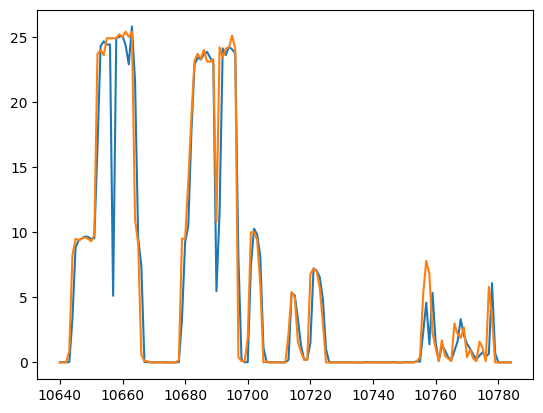

In [111]:
# for each vessel (dataframe) in the V_s list,

for shipDF in V_s:
    # set the status of each point where the avg_speed is lower than the given threshold, to 'stationary'
    shipDF['Status'] = np.where(shipDF["Avg_Speed"] < SPEED_THRESHOLD, 'stationary', shipDF['Status'])
    # set all remaining points as "sailing"
    shipDF['Status'] = np.where(shipDF["Avg_Speed"] >= SPEED_THRESHOLD, 'sailing', shipDF['Status'])
    # set the first and last points of the ship (exit points) as stationary, regardless of speed (see algorithm)
    shipDF.at[shipDF.index[0], 'Status'] = 'stationary'
    shipDF.at[shipDF.index[-1], 'Status'] = 'stationary'
    
# print a dataframe and some points just to check
interval = range(10640,10785)
print(V_s[3].iloc[interval])
plt.plot(V_s[3]['Avg_Speed'].iloc[interval])
plt.plot(V_s[3]['SOG'].iloc[interval])


In [118]:
# Extract all the stationary points in a single dataframe

stationaryDF = p.DataFrame(columns=['LAT', 'LON']) # new empty df

for vesselDF in V_s:
    extractedDF = vesselDF[vesselDF['Status'] == 'stationary']
    stationaryDF = p.concat([stationaryDF, extractedDF[['LAT', 'LON']]], ignore_index=True)

print(stationaryDF)
print(stationaryDF.shape)

/tmp/ipykernel_20382/2279343906.py:7: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



              LAT        LON
0        21.31309 -157.86712
1        21.31309 -157.86712
2        21.31309 -157.86712
3        21.31309 -157.86712
4        21.31308 -157.86712
...           ...        ...
1329424  21.29751 -157.86866
1329425  21.29752 -157.86869
1329426  21.29750 -157.86868
1329427  21.29747 -157.86870
1329428  21.29750 -157.86869

[1329429 rows x 2 columns]
(1329429, 2)


In [120]:
# Some computationl tricks in order to save some time

# Round lat and lon values to 4 decimal digits (instead of 5)
stationaryDF = stationaryDF.round(decimals=4)
# Group-by same (lat,lon) pairs and count occurrencies
groupedDF = stationaryDF.groupby(['LAT', 'LON']).size().reset_index(name='Weight')

print("Pair with most occurrencies: \n" + str(groupedDF.iloc[groupedDF['Weight'].idxmax(), :]))

# Apply log2() (base-2 logarithm) to the 'weight' column in order to reduce its values
groupedDF['Weight'] = np.round(
                                np.log2(groupedDF['Weight']),
                                decimals=0
                            )
# The minimum weight should be 1, so any zero is replaced
groupedDF['Weight'].replace(0,1,inplace=True)

print(groupedDF)

print("Pair with most occurrencies: \n" + str(groupedDF.iloc[groupedDF['Weight'].idxmax(), :]) + '\n')

Pair with most occurrencies: 
LAT          21.3068
LON        -157.8721
Weight    23360.0000
Name: 11817, dtype: float64
           LAT       LON  Weight
0      18.7671 -159.1110     1.0
1      18.7671 -157.2770     1.0
2      18.7673 -155.9327     1.0
3      18.7677 -155.7892     1.0
4      18.7687 -156.2250     1.0
...        ...       ...     ...
17459  22.6305 -155.6834     1.0
17460  22.6306 -156.1920     1.0
17461  22.6307 -156.3146     1.0
17462  22.6308 -156.8662     1.0
17463  22.6308 -155.5218     1.0

[17464 rows x 3 columns]
Pair with most occurrencies: 
LAT        21.3068
LON      -157.8721
Weight     15.0000
Name: 11817, dtype: float64



/tmp/ipykernel_20382/754193555.py:16: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





DBSCAN(eps=0.025, min_samples=30) len: 17464, num of clusters: 49
           LAT       LON  Weight  Label
0      18.7671 -159.1110     1.0     -1
1      18.7671 -157.2770     1.0     -1
2      18.7673 -155.9327     1.0     -1
3      18.7677 -155.7892     1.0     -1
4      18.7687 -156.2250     1.0     -1
...        ...       ...     ...    ...
17459  22.6305 -155.6834     1.0     -1
17460  22.6306 -156.1920     1.0     -1
17461  22.6307 -156.3146     1.0     -1
17462  22.6308 -156.8662     1.0     -1
17463  22.6308 -155.5218     1.0     -1

[17464 rows x 4 columns]


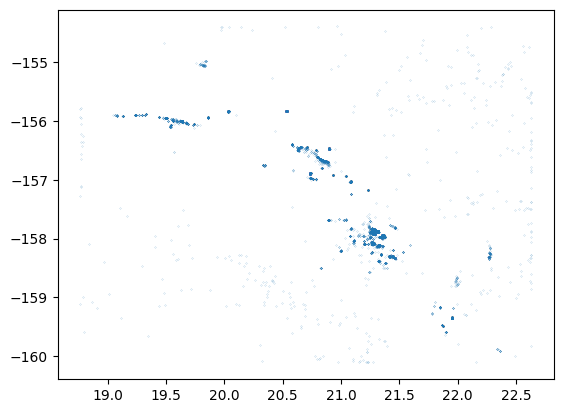

In [121]:
# Run DBSCAN algorithm on the stationary points

plt.scatter(groupedDF.iloc[:,0], groupedDF.iloc[:,1], s=0.01)

dbscan = DBSCAN(eps=0.025, min_samples=30)

estimator = dbscan.fit(
                    X=groupedDF.iloc[:, :2], 
                    sample_weight=groupedDF['Weight']
                    )


print(str(estimator) + " len: " + str(len(estimator.labels_)) + ", num of clusters: " + str(max(estimator.labels_)))

# Add labels to dataframe
groupedDF['Label'] = estimator.labels_

print(groupedDF)

In [116]:
import plotly.express as px
import plotly.offline as po

fig = px.scatter_mapbox(groupedDF,
                        lon = groupedDF['LON'],
                        lat= groupedDF['LAT'],
                        zoom = 5,
                        color = groupedDF['Label'],
                        title = 'Clustered stationary points'
                        )

fig.update_layout(mapbox_style = 'open-street-map')

po.plot(fig)

'temp-plot.html'